In [25]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG, SPSA
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType, Hamiltonian, TransformationType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import circuit_drawer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [10]:
from qiskit import IBMQ
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-06-21 11:54:13,782: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
def add_unitary_gate(circuit,qubit1,qubit2,params,p0):
    circuit.s(qubit1)
    circuit.s(qubit2)
    circuit.h(qubit2)
    circuit.cx(qubit2,qubit1)
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit1); p0 += 3
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit2); p0 += 3
    circuit.cx(qubit2,qubit1)
    circuit.h(qubit2)
    circuit.sdg(qubit1)
    circuit.sdg(qubit2)
    
class SO_04(VariationalForm):
    
    def __init__(self, numqubits):
        self._num_qubits = numqubits
        self._num_parameters = 6*(numqubits-1)
               
    def construct_circuit(self, parameters):
        q = QuantumRegister(self._num_qubits, name='q')
        circ = QuantumCircuit(q)
        
        #initial state       
        #circ.x(0)
        #circ.x(1)
        
        if self._num_qubits == 4:        
            add_unitary_gate(circ, 0, 1, parameters, 0)
            add_unitary_gate(circ, 2, 3, parameters, 6)
            add_unitary_gate(circ, 1, 2, parameters, 12)
            
        return circ
    
    @property
    def num_parameters(self):
        return self._num_parameters    

In [32]:
lastparam = {}
    
lastparam['TwoLocal(ry)'] = np.ones(12)   
lastparam['SO(4)'] = np.ones(18)   
lastparam['UCCSD'] = np.ones(8)

In [35]:
def vqe_function(geometry, basis = 'sto-6g', var_form_type = 'TwoLocal(ry)', 
                 quantum_instance = Aer.get_backend("statevector_simulator"),
                 optimizer = CG(maxiter=1000,disp=True,eps=1e-1,tol=1e-2)):
    
    #optimizer = CG(maxiter=1000, disp = True, eps=1e-1)
    #optimizer = SPSA(maxiter=1000) 
        
        
    two_qubit_reduction = True
    qubit_mapping = 'parity'
    
    charge = 1
    spin = 0
    driver = PySCFDriver(atom = geometry,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis=basis,hf_method=HFMethodType.RHF)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = TwoLocal() #dummy
    
    
    init_parm = lastparam[var_form_type]
    
    if var_form_type == 'TwoLocal(ry)':
        var_form = TwoLocal(rotation_blocks=['ry'], entanglement_blocks='cx',
                            num_qubits=4,
                            reps=2,
                            #initial_state=initial_state,
                            entanglement='linear')
        
    if var_form_type == 'TwoLocal(ry_rz)':
        var_form = TwoLocal(rotation_blocks=['ry','rz'], entanglement_blocks='cz',
                            num_qubits=4,
                            #initial_state=initial_state,
                            entanglement='linear')
    
    if var_form_type == 'UCCSD':
        var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
        
    if var_form_type == 'SO(4)':
        var_form = SO_04(4)
    
    
    
    
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(quantum_instance)
    
    lastparam[var_form_type] = vqe.optimal_params
    
    result = np.real(vqe_result_tot['eigenvalue'])
    
    return np.real(vqe_result_tot['eigenvalue'] + shift) 


In [ ]:
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_santiago")

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
seed = 150
aqua_globals.random_seed = seed

quantum_instance_corr = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                                    coupling_map=coupling_map, noise_model=noise_model,shots=8000,
                                    measurement_error_mitigation_cls=CompleteMeasFitter,
                                    measurement_error_mitigation_shots=1000)
        
quantum_instance_norm = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                                    coupling_map=coupling_map, noise_model=noise_model,shots=8000)
        
        
dist = np.arange(0.2, 3.5, .1)
alt = np.sqrt(dist**2 - (dist/2)**2)

energies = {}

energies["corr"] = []
energies["norm"] = []

errors = {}
errors["corr"] = []
errors["norm"] = []



for i in range(len(dist)):
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    
    result_corr = vqe_function(geometry, quantum_instance = quantum_instance_corr)
    
    result_norm = vqe_function(geometry, quantum_instance = quantum_instance_norm)
    
    energies["corr"].append(result_corr)
    
    energies["norm"].append(result_norm)
    
    print("Distanza ",np.round(dist[i],2), 
          "\n\t corr: ", result_corr,
          "\n\t norm: ", result_norm)   

In [18]:
#CG(maxiter=1000,disp=True,eps=1e-1,tol=1e-2)

dist = np.arange(0.2, 3.5, .1)

energies = {}

energies["corr"] = [
    3.3419280863907828,
    0.9266535966215592,
    -0.11136581123083555,
    -0.6621105664910738,
  -0.940492154649069,
  -1.1036814862320163,
  -1.1610243781936223,
  -1.2192011304013872,
  -1.2245431897557202,
    -1.1967083066496484,
  -1.2052190958789244,
  -1.1870585026478433,
  -1.1226344595168511,
  -1.120184031665857, #1.5
  -1.1058820131965486,
  -1.1607676434461407,
  -1.1664081824670316,
  -1.1610848851966136,
  -1.164722407797265,
  -1.1624041128613487,
  -1.1559759518630246,
  -1.0408966414692877,
  -1.1403524544324624,
  -1.137690425798121,
  -1.0975267928918893,
  -1.068618152443735,
  -1.0646089667594887,
  -1.0736923783957089,
  -1.0772556232685406,
  -1.0835846477359636,
  -1.0789215728365362,
  -1.0891953794216236,
  -1.073702264017705
]
energies["norm"] = [
    3.4691418858098517,
    1.026312122188184,
    -0.058479235441962096,
    -0.5992219587014502,
  -0.8912142571664705,
  -1.057631474601544,
  -1.1409123443596447,
  -1.1856785663893603,
  -1.2025895807527966,
    -1.1839864205620927,
  -1.1807675913842939,
  -1.1457996913077317,
  -1.1067565681796638,
  -1.1117433817036841,
  -1.0739004093670896,
  -1.1341517129213932,
  -1.1545457727363366,
  -1.1540105358788129,
  -1.148436571617514,
  -1.1291129969696347,
  -1.1382380077095724,
  -1.027458026014505,
  -1.127522088894084,
  -1.0494859670831929,
  -1.0595897818420092,
  -1.0562829472578577,
  -0.9770182635977946,
  -1.0648923255138283,
  -1.0677100498050405,
  -1.0707305094041617,
  -1.0791287020412565,
  -1.0740592409008076,
  -1.071756974223133
]


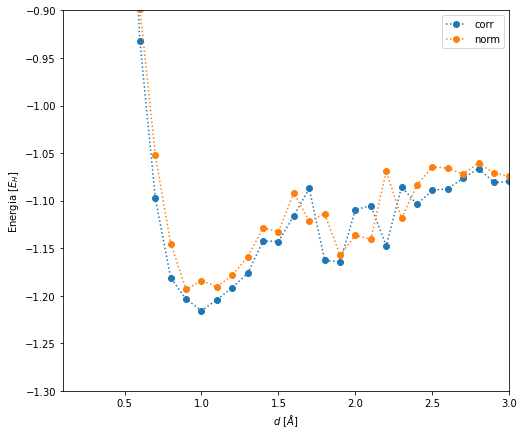

In [31]:
MIN = 2.5
MAX = 3.6

YMIN = -1.2
YMAX = -1.

fig, ax = plt.subplots(figsize=[8, 7])

for (method,E) in energies.items():
    #if method == 'TwoLocal(ry)':
    #    plt.plot(dist,E,'bo',label=method)
    if method == 'FCI' or method =='HF':
        plt.plot(dist,E,'-',label=method)
   # elif method == "TwoLocal_statevector":
    else:
        plt.plot(dist,E,'o:',label=method)
   # else:    
       # plt.errorbar(dist,E, yerr = errors['TwoLocal_noise'], fmt='o:',label=method)
    
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energia $[E_H]$")
plt.legend()
plt.ylim([-1.3, -.9])
plt.xlim([0.1, 3.])




#plt.ylim([-1.3, .0])
#plt.xlim([0.5, 1.5])

#plt.title('SIMULAZIONI VQE SENZA RUMORE E CON INITIAL STATE')
#plt.savefig('figura.pdf')
plt.show()